In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [2]:
# You will generate a synthetic data set consisting of two classes (class 0 and class 1) with 20 features and 2000 samples each. 
# Class 0 should come from the multivariate Gaussian distribution with mean 2.0 while Class 1 should come from the multivariate Gaussian distribution with mean 1.3. 
# The two classes should share the same covariance matrix.

knn_data = np.random.multivariate_normal(mean = [2.0, 1.3], cov = [[1, 0], [0, 1]], size = (2000, 20))

In [3]:
# Label the data points with the corresponding class number 

class0 = pd.DataFrame(knn_data[:, :, 0])
class0['target'] = 0
class1 = pd.DataFrame(knn_data[:, :, 1])
class1['target'] = 1

In [4]:
# Regroup everything into a single dataframe

input_df = pd.concat([class0, class1], ignore_index=True)

In [5]:
# Rename the data to differentiate between features and target values
X = input_df.drop(columns=['target']).values # features
y = input_df.target.values # target

# randomly pick 30% of each class as a test set (this is done by setting stratify=y). tr an te subscripts determine the training and test sets.
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0) 

# Double check dimensions for the data:
print('Train set: {:}'.format(X_tr.shape), 'Test set: {:}'.format(X_te.shape))

Train set: (2800, 20) Test set: (1200, 20)


In [6]:
# Implement and train a k-nn classifier on the remaining 70%. Test the classifier on the left out 30\% and report the best fit accuracy, precision, and recall achieved by this classifier. 

knn = KNeighborsClassifier(n_neighbors=5).fit(X_tr, y_tr) # knn fit on the training set
knn_pred = knn.predict(X_te) # knn prediction on the test set
accuracy = knn.score(X_te, y_te) # accuracy calculation
precision = precision_score(y_te, knn_pred) # precision calculation
recall = recall_score(y_te, knn_pred) # recall calculation
print('The test metrics for {}'.format(knn.n_neighbors),'neighbours are: accuracy = {:.2f}'.format(accuracy), 'precision = {:.2f}'.format(precision), 'and recall = {:.2f}'.format(recall))

The test metrics for 5 neighbours are: accuracy = 0.91 precision = 0.91 and recall = 0.91


In [7]:
# Repeat the experiment for different values of k.
# Instead of testing separately a series of values, I will define a nearest neighbors value list and iterate through it with the help of a grid. 
# I will also include a pipeline to insert a scaling step to normalize the distance between neighbours.

knn_pipe = Pipeline([
    ('scaler', StandardScaler()), # scaling step
    ('knn', KNeighborsClassifier()) # knn step
])

k_values = list(np.arange(1, 21, 1)) + [50, 100, 150, 200, 250, 500] # step of 1 for low figures, and larger steps further on

knn_grid = ParameterGrid({
    'knn__n_neighbors' : k_values,
})

# Save accuracy, precision and recall at each step
knn_scores = []

for i in knn_grid:
    # Set parameters
    knn_pipe.set_params(**i)

    # Fit the k-NN classifier
    knn_pipe.fit(X_tr, y_tr)

    # predict the values on the test set
    knn_pred = knn_pipe.predict(X_te)
    
    # Save score metrics
    i['accuracy'] = knn_pipe.score(X_te, y_te)
    i['precision'] = precision_score(y_te, knn_pred)
    i['recall'] = recall_score(y_te, knn_pred)

    # Save results
    knn_scores.append(i)
    
knn_search = pd.DataFrame(knn_scores)

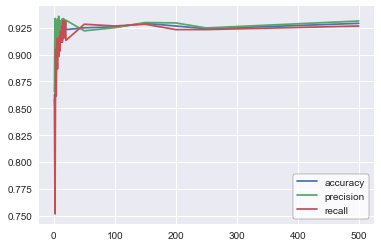

In [8]:
# Are there particular values of k which perform better?

sns.set()
plt.plot(knn_search.knn__n_neighbors, knn_search.accuracy)
plt.plot(knn_search.knn__n_neighbors, knn_search.precision)
plt.plot(knn_search.knn__n_neighbors, knn_search.recall)
plt.legend(frameon=True, facecolor='white', edgecolor='black')
plt.show()

In [9]:
# Are there particular values of k which perform better?
# It looks like k values between 150 and 250 perform better than the rest. 

knn_search.sort_values(by='accuracy', ascending=False).head()

,accuracy,knn__n_neighbors,precision,recall
25,0.929167,500,0.931323,0.926667
22,0.929167,150,0.929883,0.928333
18,0.929167,19,0.927032,0.931667
14,0.929167,15,0.927032,0.931667
23,0.926667,200,0.929530,0.923333


In [10]:
# Discuss possible approaches for finding the best value of k.
# An alternative approach would be to do cross-validation rather than a train/test setup. 

scoring = ['accuracy', 'precision', 'recall']

# Create cross-validation object with a stratified 10-fold cross-validation strategy, custom parameter grid for knn, and evaluation of 3 different metrics (selection of best parameters will be decided on 'accuracy' though). 
grid_knn = GridSearchCV(knn_pipe, {
    'knn__n_neighbors' : k_values}, cv=10, return_train_score=False, scoring=scoring, refit='accuracy')

# Fit the cross-validation grid
grid_knn.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=500, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 50, 100, 150, 200, 250, 500]},
       pre_dispatch='2*n_jobs', refit='accuracy', return_train_score=False,
       scoring=['accuracy', 'precision', 'recall'], verbose=0)

In [15]:
print('The test metrics for {}'.format(list(grid_knn.best_params_.values())[0]),'neighbours are: accuracy = {:.2f}'.format(grid_knn.best_score_), 'precision = {:.2f}'.format(pd.DataFrame(grid_knn.cv_results_).loc[grid_knn.best_index_,:]['mean_test_precision']), 'and recall = {:.2f}'.format(pd.DataFrame(grid_knn.cv_results_).loc[grid_knn.best_index_,:]['mean_test_recall']))

The test metrics for 250 neighbours are: accuracy = 0.93 precision = 0.93 and recall = 0.93


#### Suppose that instead of starting with two equally sized classes you would have 2000 samples in Class 0 but only 100 samples in Class 1. Discuss how you would change your approach for the classification task. 

This would be a classification task with an imbalanced dataset. There are several ways to tackle imbalance in classification:

- Data undersampling, which consists in taking a subset of the majority class with the same amount of samples as the ones available in the minority class. The model fitting might depend greatly on the chosen subset, so a type of validation might be needed.
- Data oversampling, which consists in repeating samples from the minority class until reaching the same number of samples from the majority class. 
- Data weighting, which consists in assigning a weight to the minority class in the form of a multiplier, and thus increasing the importance of those observations during fitting.
- Use hyperparameter-tuned ensemble algorithms for model fitting, as these can be pretty insensitive to class imbalance (but might tend to overfit though).

In [58]:
# The following model reproduces the same example as before but including class imbalance. As an example, the data will be undersampled.

zero = (y == 0)
X_i = np.concatenate((X[zero], X[~zero][0:100]))
y_i = np.concatenate((y[zero], y[~zero][0:100]))
X_i_tr = np.concatenate((X[zero][0:70], X[~zero][0:70]))
y_i_tr = np.concatenate((y[zero][0:70], y[~zero][0:70]))
X_i_te = np.concatenate((X[zero][70:], X[~zero][70:100]))
y_i_te = np.concatenate((y[zero][70:], y[~zero][70:100]))

In [59]:
# Create cross-validation object with a stratified 10-fold cross-validation strategy, custom parameter grid for knn, and evaluation of 3 different metrics (selection of best parameters will be decided on 'accuracy' though). 
k_values_i = list(np.arange(1, 21, 1)) + [50, 100]

grid_knn_i = GridSearchCV(knn_pipe, {
    'knn__n_neighbors' : k_values_i}, cv=10, return_train_score=False, scoring=scoring, refit='accuracy')

# Fit the cross-validation grid
grid_knn_i.fit(X_i_tr, y_i_tr)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=500, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit='accuracy', return_train_score=False,
       scoring=['accuracy', 'precision', 'recall'], verbose=0)

In [60]:
print('The cross-validated metrics on the undersampled set for {}'.format(list(grid_knn_i.best_params_.values())[0]),'neighbours are: accuracy = {:.2f}'.format(grid_knn_i.best_score_), 'precision = {:.2f}'.format(pd.DataFrame(grid_knn_i.cv_results_).loc[grid_knn_i.best_index_,:]['mean_test_precision']), 'and recall = {:.2f}'.format(pd.DataFrame(grid_knn_i.cv_results_).loc[grid_knn_i.best_index_,:]['mean_test_recall']))
print('The test metrics on the unseen test set are accuracy = {:.2f}'.format(grid_knn_i.score(X_i_te, y_i_te)), 'precision = {:.2f}'.format(precision_score(grid_knn_i.predict(X_i_te), y_i_te)), 'and recall = {:.2f}'.format(recall_score(grid_knn_i.predict(X_i_te), y_i_te)))

The cross-validated metrics on the undersampled set for 11 neighbours are: accuracy = 0.96 precision = 0.99 and recall = 0.93
The test metrics on the unseen test set are accuracy = 0.93 precision = 0.77 and recall = 0.14
